In [0]:
!nvidia-smi

Sat Dec  7 20:02:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os

# Model & Data Setup
You should not have to make any modifications to the below code (unless your
specific part requires it)

Also -- the changing Learning Rate has not been implemented in the model, so 
that will require a change

In [0]:
def load_data(loc):
    data = loadmat(loc)
    return data['X'], data['y']

In [0]:
if not os.path.exists('data'):
    ! mkdir data
    ! wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
    ! wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
    # ! wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat
    ! mv *.mat data

--2019-12-07 20:02:18--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  14.8MB/s    in 14s     

2019-12-07 20:02:33 (12.0 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-12-07 20:02:34--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  13.9MB/s    in 5.7s    

2019-12-07 20:02:40 (10.7 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [0]:
X_train, Y_train = load_data('data/train_32x32.mat')
X_test, Y_test = load_data('data/test_32x32.mat')
X_train = np.transpose(X_train, (3,0,1,2))
X_test = np.transpose(X_test, (3,0,1,2))
print("Training Set", X_train.shape, Y_train.shape)
print("Test Set", X_test.shape, Y_test.shape)

Training Set (73257, 32, 32, 3) (73257, 1)
Test Set (26032, 32, 32, 3) (26032, 1)


In [0]:
normalizer = 1/255
X_train = X_train * normalizer
X_test = X_test * normalizer

In [0]:
def data_size(trX, trY, tsX, tsY, trNum=10000, tsNum=2000, valNum=500):
    vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    newTrX = []
    newTrY = []
    newTsX = []
    newTsY = []
    valX = []
    valY = []
    for i in vals:
        indices = np.where(trY == [i])[0]
        for num in range((int)(trNum/10)):
            newTrX.append(trX[indices[num]])
            newTrY.append(trY[indices[num]][0])
        indices = np.where(tsY == [i])[0]
        for num in range(((int)(tsNum/10))+((int)(valNum/10))):
            if num < (tsNum/10):
                newTsX.append(tsX[indices[num]])
                newTsY.append(tsY[indices[num]][0])
            else:
                #valX.append(tsX[indices[num]])
                valX.append(np.copy(tsX[indices[num]]))
                valY.append(tsY[indices[num]][0])
    
    return np.asarray(newTrX).reshape(trNum, 32, 32, 3), np.asarray(newTrY).reshape(trNum, 1), np.asarray(newTsX).reshape(tsNum, 32, 32, 3), np.asarray(newTsY).reshape(tsNum, 1), np.asarray(valX).reshape(valNum, 32, 32, 3), np.asarray(valY).reshape(valNum,1)

In [0]:
trX, trY, tsX, tsY, valX, valY = data_size(X_train, Y_train, X_test, Y_test)

In [0]:
print(trX.shape)
print(trY.shape)
print(tsX.shape)
print(tsY.shape)
print(valX.shape)
print(valY.shape)
trY[trY == 10] = 0
tsY[tsY == 10] = 0
valY[valY == 10] = 0
trY = keras.utils.to_categorical(trY, 10)
tsY = keras.utils.to_categorical(tsY, 10)
valY = keras.utils.to_categorical(valY, 10)

(10000, 32, 32, 3)
(10000, 1)
(2000, 32, 32, 3)
(2000, 1)
(500, 32, 32, 3)
(500, 1)


In [0]:
print(trX.shape)
print(trY.shape)
print(tsX.shape)
print(tsY.shape)
print(valX.shape)
print(valY.shape)

(10000, 32, 32, 3)
(10000, 10)
(2000, 32, 32, 3)
(2000, 10)
(500, 32, 32, 3)
(500, 10)


In [0]:
# DO NOT MODIFY THIS METHOD
class CNN_Model():
    def __init__(self, lr_0=0.01, delta=1e-6, B=32, p_1=0.1, p_2=0.1):
        '''
        All the parameters exposed are those we need to tune for the]
        project
        '''

        self.lr_0 = lr_0 # Starting Learning Rate
        self.delta = delta # Learning Rate Decay
        self.B = B # Mini-Batch Size
        self.p_1 = p_1 # Dropout Parameter 1
        self.p_2 = p_2 # Dropout Parameter 2
    
    def define_model(self):
        '''
        Defines the model with the given parameters
        TODO: Learning Rate Decay in Keras
        '''
        DATAFORMAT = "channels_last"

        # Input to model
        inputs = Input(shape=(32, 32, 3), name='input') # TODO: assuming input size is 784
        # Convolutional Layers
        conv1 = Conv2D(filters=32, kernel_size=(5,5), padding='same',
                       data_format=DATAFORMAT, strides=1, name='conv1')(inputs)
        conv2 = Conv2D(filters=64, kernel_size=(3,3), padding='same',
                       data_format=DATAFORMAT, strides=1, name='conv2')(conv1)
        conv3 = Conv2D(filters=128, kernel_size=(3,3), padding='same',
                       data_format=DATAFORMAT, strides=1, name='conv3')(conv2)

        flatten = Flatten(data_format=DATAFORMAT)(conv3)
        
        # Fully-Connected Layers
        fc1 = Dense(1024, activation='relu', name='fc1')(flatten)
        drop1 = Dropout(self.p_1, name='drop1')(fc1)
        fc2 = Dense(1024, activation='relu', name='fc2')(drop1)
        drop2 = Dropout(self.p_2, name='drop2')(fc2)
        fc3 = Dense(10, activation='softmax', name='output')(drop2)

        model_ = Model(inputs=inputs, outputs=fc3)
        optim = SGD(lr=self.lr_0, decay=self.delta)
        model_.compile(optimizer=optim,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        self.model = model_
    
    def train_model(self, x, y, valX=None, valY=None, epochs=15):
        '''
        Trains the model.
        '''
        val_data = (valX, valY)
        self.train_history = self.model.fit(x, y, batch_size=self.B, epochs=epochs, verbose=0,
                    validation_data=val_data)
        


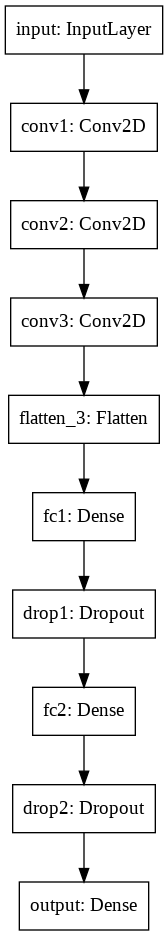

In [0]:
cnn = CNN_Model(B=1024)
cnn.define_model()
plot_model(cnn.model)

In [0]:
#cnn.train_model(trX, trY, valX, valY)

# Hyperparameter Experiments

## Using Grid Search

In [0]:
grid_lr = [1e-1, 1e-3, 1e-5, 1e-6] # ref: https://bit.ly/2L9Frj7
grid_delta = [0, 1e-1, 1e-3, 1e-4, 1e-6, 1e-8, 1e-10]
grid_B = [32, 64, 128, 256, 512, 1024][::-1]
grid_p1 = [0.1*i for i in range(1,6)]
grid_p2 = [0.1*i for i in range(1,6)]



In [0]:
grid_lr = [1e-3, 1e-5, 1e-6] # ref: https://bit.ly/2L9Frj7
grid_delta = [0, 1e-1, 1e-3, 1e-4, 1e-6, 1e-8, 1e-10]
grid_B = [32, 64, 128, 256, 512, 1024][::-1]
grid_p1 = [0.1*i for i in range(1,6)]
grid_p2 = [0.1*i for i in range(1,6)]

from random import shuffle

In [0]:
# Grid Search!
best_val_loss = 1.4572559852600098
best_params = {'lr': 0.1, 'delta': 0.1, 'B': 128, 'p1': 0.4, 'p2': 0.1, 'iteration': 241}
gs_iteration = 885
best_iteration = 241
search_space = []
## hacky but gets the job done
for lr in grid_lr:
    for delta in grid_delta:
        for B in grid_B:
            for p1 in grid_p1:
                for p2 in grid_p2:
                    search_space.append((lr, delta, B, p1, p2))
shuffle(search_space)
for lr, delta, B, p1, p2 in search_space:
    gs_iteration += 1
    if (gs_iteration % 5) == 0:
        print(f'Iteration {gs_iteration}: Val Loss={best_val_loss}. Params={best_params}')
    cnn = CNN_Model(lr_0=lr, delta=delta, B=B, p_1=p1, p_2=p2)
    cnn.define_model()
    cnn.train_model(trX, trY, valX, valY)
    val_loss = np.nanmin(cnn.train_history.history['val_loss']) # ignore nan's
    del(cnn)
    K.clear_session()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {'lr':lr, 'delta':delta, 'B':B, 'p1': p1,
                        'p2': p2, 'iteration': gs_iteration}
        best_iteration = gs_iteration
        print('New best val loss!')
        print(f'Iteration {gs_iteration}: Val Loss={best_val_loss}. Params={best_params}')                    

Iteration 890: Val Loss=1.4572559852600098. Params={'lr': 0.1, 'delta': 0.1, 'B': 128, 'p1': 0.4, 'p2': 0.1, 'iteration': 241}
Iteration 895: Val Loss=1.4572559852600098. Params={'lr': 0.1, 'delta': 0.1, 'B': 128, 'p1': 0.4, 'p2': 0.1, 'iteration': 241}
Iteration 900: Val Loss=1.4572559852600098. Params={'lr': 0.1, 'delta': 0.1, 'B': 128, 'p1': 0.4, 'p2': 0.1, 'iteration': 241}
New best val loss!
Iteration 900: Val Loss=1.3852515563964845. Params={'lr': 0.001, 'delta': 0, 'B': 32, 'p1': 0.2, 'p2': 0.1, 'iteration': 900}
Iteration 905: Val Loss=1.3852515563964845. Params={'lr': 0.001, 'delta': 0, 'B': 32, 'p1': 0.2, 'p2': 0.1, 'iteration': 900}
Iteration 910: Val Loss=1.3852515563964845. Params={'lr': 0.001, 'delta': 0, 'B': 32, 'p1': 0.2, 'p2': 0.1, 'iteration': 900}
Iteration 915: Val Loss=1.3852515563964845. Params={'lr': 0.001, 'delta': 0, 'B': 32, 'p1': 0.2, 'p2': 0.1, 'iteration': 900}
Iteration 920: Val Loss=1.3852515563964845. Params={'lr': 0.001, 'delta': 0, 'B': 32, 'p1': 0.2,

In [0]:
print(f'Best Validation Loss:\t {best_val_loss}')
print(f'Best parameters:\t {best_params} ')
print(f'Number of total iterations: \t {gs_iteration}')
print(f'Best iteration:\t {best_iteration}')

## Using Bayesian Global Optimization

In [0]:
!pip install bayesian-optimization
# Using Open-Source Bayesian-Optimization library:
# https://github.com/fmfn/BayesianOptimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=585dbef8de1c0134bcb2a6aba72df78ae647a7b2ce12beba26ebd5a8755dd419
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
from bayes_opt import BayesianOptimization

def func(lr_0, B, delta, p_1, p_2):
    B = max(int(B*320),1)
    cnn = CNN_Model(lr_0, delta, B, p_1, p_2)
    cnn.define_model()
    cnn.train_model(trX, trY, valX, valY)
    val_loss = np.nanmin(cnn.train_history.history['val_loss'])
    #print('loss:', val_loss)
    del cnn
    K.clear_session()
    return (-1*val_loss) # nigative value to be fed to the maximize function

#param_bounds = {'lr_0': (1e-6, 1e-2), 'delta': (1e-2, 1e-10), 'B': (32, 1024), 'p_1': (0.1, 0.5), 'p_2': (0.1, 0.5)}
param_bounds = {
    'lr_0': (1e-6, 1e-1),
    'delta': (1e-10, 0),
    'B': (0.1, 3.2),
    'p_1': (0.1, 0.6),
    'p_2': (0.1, 0.6)
    }

optimizer = BayesianOptimization(f=func, pbounds=param_bounds, verbose=2, random_state=42)
optimizer.maximize(init_points=30, n_iter=70)
print(optimizer.max)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   |     B     |   delta   |   lr_0    |    p_1    |    p_2    |
-------------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
|  1        | -2.203    |  1.261    |  4.929e-1 |  0.0732   |  0.3993   |  0.178    |
|  2        | -2.303    |  0.5836   |  9.419e-1 |  0.08662  |  0.4006   |  0.454    |
|  3        | -2.303    |  0.1638   |  3.009e-1 |  0.08324  |  0.2062   |  0.1909   |
|  4        | -2.233    |  0.6686   |  6.958e-1 |  0.05248  |  0.316    |  0.2456   |
|  5        | -1.414    |  1.997    |  8.605e-1 |  0.02922  |  0.2832   |  0.328    |
|  6        | -1.995    |  2.534    |  8.003e-1 |  0.05142  |  0.3962   |  0.1232   |
|  7        | -2.278    |  1.983    |  8.295e-1 |  0.006506 |  0.5744   |  0.5828   |
|  8        | -2.296    |  2.606    |  6.954e-1 |  0.009768 |  0.4421   |  0.3201   |
|  9        | -2.18     |  0.4783   |  5.048e-1 |  0.00344 